Whats new to this notebook? I used a new version from the original dataset, implemented feature engineering and selection, and explored the data with more models.

# Feature Engineering and Selection

## Imports

In [47]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## Import the clean data set

In [48]:
df = pd.read_csv('../Resources/Clean_Insurance_Data.csv', decimal='.', delimiter=',')
df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91.0,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87.0,No,0,No,southeast,1131.51
2,2,3,38.0,male,33.3,82.0,Yes,0,No,southeast,1135.94
3,3,4,38.0,male,33.7,80.0,No,0,No,northwest,1136.40
4,4,5,38.0,male,34.1,100.0,No,0,No,northwest,1137.01


# Feature Creation
Feature engineering is crucial for machine learning models. Here, one-hot encoding is applied to the *diabetic*, *smoker*, and *gender* columns, transforming categorical data into a binary format suitable for model input.

In [49]:
# irrelevant features
df = df.drop(['claim', 'PatientID', 'index', 'region'], axis=1) 

df['diabetic'] = df['diabetic'].map({'Yes': 1, 'No': 0})  
df['gender'] = df['gender'].map({'male': 1, 'female': 0}) 
df['smoker'] = df['smoker'].map({'No': 0, 'Yes': 1})

# convert the bloodpressure column to int for future use 
df['bloodpressure'] = df['bloodpressure'].astype(int)
df.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker
0,39.0,1,23.2,91,1,0,0
1,24.0,1,30.1,87,0,0,0
2,38.0,1,33.3,82,1,0,0
3,38.0,1,33.7,80,0,0,0
4,38.0,1,34.1,100,0,0,0


Save the new data set to a CSV file for use in the next notebook.

In [50]:
df.to_csv('../Resources/Feature_Engineered_Insurance_Data.csv', index=False)

# Feature selection
Feature selection is a process where we aim to choose those attributes of the data that contribute most significantly to our prediction variable or output in which we are interested. The benefits of feature selection include simplification of models, faster training times, and avoidance of the curse of dimensionality.

#### Feature selection using machine-learning

In [51]:
X = df.drop('bloodpressure', axis=1)
y = df['bloodpressure'] 

# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicting on training and testing data
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Feature Importance
feature_importance = clf.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df.sort_values(by='Importance', ascending=False, inplace=True)

features_df.head()

,Feature,Importance
2,bmi,0.445158
0,age,0.250154
4,children,0.153433
3,diabetic,0.087356
1,gender,0.054606


1. *bmi, 0.445158*: This indicates a moderate positive correlation between the 'bmi' feature and 'bloodpressure'. A higher BMI tends to be associated with higher blood pressure. The correlation coefficient of approximately 0.445 suggests that as BMI increases, blood pressure also tends to increase, but the relationship is not extremely strong.

2. *age, 0.250154*: This shows a mild positive correlation between 'age' and 'bloodpressure'. It suggests that blood pressure tends to increase with age, but the relationship is less strong compared to BMI. The correlation coefficient of around 0.25 indicates a weaker, though still present, positive relationship.

3. *children, 0.153433*: This coefficient indicates a weak positive correlation between the number of children and blood pressure. It suggests a slight tendency for blood pressure to increase with the number of children, but the relationship is relatively weak.

4. *diabetic, 0.087356*: This low positive correlation coefficient implies a very weak relationship between being diabetic and blood pressure. The indication is that diabetics might have slightly higher blood pressure on average, but the correlation is too weak to draw strong conclusions.

5. *gender, 0.054606*: This very low positive correlation suggests almost no linear relationship between gender and blood pressure. The value indicates that gender has little to no direct linear effect on blood pressure in this dataset.

#### Feature selection using a correlation matrix

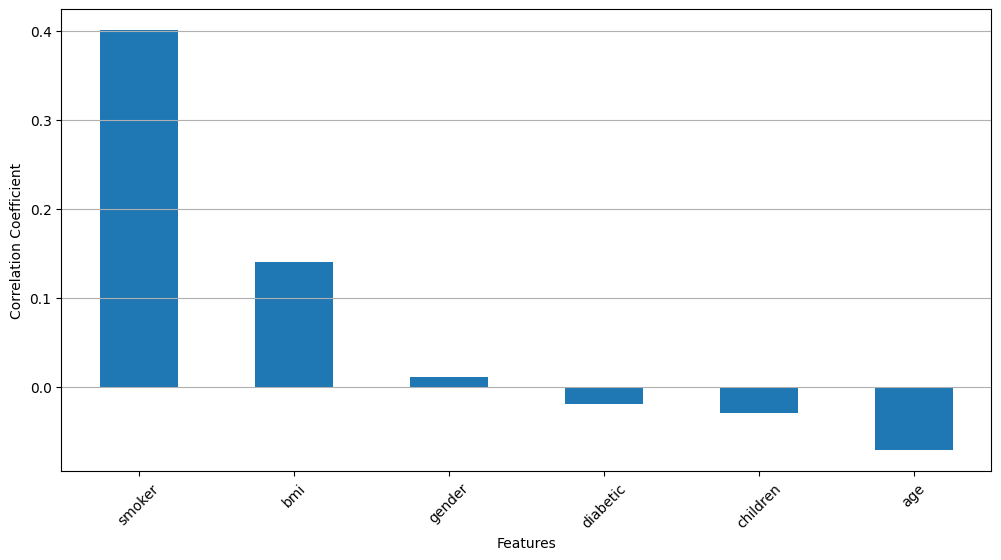

In [52]:
correlation_matrix = df.corr()
correlation = correlation_matrix['bloodpressure'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
correlation.drop('bloodpressure').plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()  

1. *Smoker, 0.400758*: This shows a moderate positive correlation with the outcome. It suggests that being a smoker is associated with an increase in the outcome measure. The value indicates a significant relationship, though not extremely strong.

2. *BMI, 0.140428*: This indicates a mild positive correlation between BMI and the outcome. It suggests that higher BMI is somewhat associated with an increase in the outcome, but the relationship is relatively weaker compared to smoking status.

3. *Gender, 0.011389*: This very low correlation suggests almost no linear relationship between gender and the outcome. Gender has a negligible direct effect on this outcome in this dataset.

4. *Diabetic, -0.019231*: This low negative correlation implies a very weak inverse relationship between being diabetic and the outcome. It indicates that diabetics might have a slightly lower measure of the outcome, but the correlation is too weak to draw significant conclusions.

5. *Children, -0.029470*: This indicates a weak negative correlation. It suggests a slight tendency for the outcome to decrease with an increasing number of children, but the relationship is quite weak.

6. *Age, -0.071712*: This is a weak negative correlation, indicating that older individuals might have a slightly lower measure of the outcome. However, the relationship is not strong.  

**Important Note:** Correlation does not imply causation. High correlation means there is a linear relationship, but it doesn’t necessarily mean that one feature causes the other to change.

## Feature selection using statistical tests
 
I'll use statistical tests (this notebook uses chi-squared) to select features with the strongest relationship with the output variable. This method helps in understanding which features have the most significant impact on the prediction.

In [53]:
X = df.drop('bloodpressure', axis=1) 
y = df['bloodpressure'] 
chi2_selector = SelectKBest(chi2, k='all') 
X_kbest = chi2_selector.fit_transform(X, y)
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_)), columns=['feature', 'score'])
chi2_scores = chi2_scores.sort_values(by='score', ascending=False)
chi2_scores

,feature,score
5,smoker,287.813124
0,age,158.086850
2,bmi,68.292760
4,children,31.321816
3,diabetic,21.919681
1,gender,19.282881


1. *Smoker (287.813124)*: This is the highest score among the features, indicating that 'smoker' is the most significant predictor in the model. Its high score suggests that whether a person is a smoker or not plays a crucial role in determining the outcome.

2. *Age (158.086850)*: The second-highest score, for 'age', implies that this feature is also a strong predictor, but less so than 'smoker'. Age has a substantial impact on the model's predictions.

3. *BMI (68.292760)*: This score for 'bmi' shows it's a moderately important feature in the model. It has a significant but lesser influence compared to 'smoker' and 'age'.

4. *Children (31.321816)*: The number of children has a lower score, suggesting it's a less significant predictor in the model compared to the above features. It plays a role but is not a primary factor.

5. *Diabetic (21.919681)*: This has a lower importance score, indicating that being diabetic has some influence on the model's prediction but is not among the top factors.

6. *Gender (19.282881)*: Gender has the lowest score among the features listed, suggesting it has the least influence on the model's predictions in this context.

## Top 3 most relevant features in correlation to the target variable

- **Smoker**: It has the highest feature importance score in the third set and the highest positive correlation in the first set, indicating a strong and consistent influence on blood pressure.

- **BMI**: BMI appears in the top three across all sets - it has a moderate to high correlation with blood pressure in both the first and second sets and a significant feature importance score in the third set.

- **Age**: Age also consistently appears as a significant factor. It has a moderate positive correlation in the second set and a substantial feature importance score in the third set.

## Variance

Variance analysis helps in understanding the spread of the data. It is crucial for identifying features with high variance, which are often more informative for models.

- High variance in continuous variables like age, BMI, and blood pressure suggests a wide range of these features in your dataset, which can be significant for understanding the dataset's diversity.
- For binary variables like gender, diabetic, and smoker, the variance can give you an idea about the distribution balance between the two categories.

In [54]:
variances = df.var() 
variances

age              122.814617
gender             0.250151
bmi               36.801863
bloodpressure     96.737064
diabetic           0.249750
children           1.452830
smoker             0.162788
dtype: float64

## Bias
 A model with high bias pays very little attention to the training data and oversimplifies the model (underfitting). This isn't directly calculated from the data but is inferred from the model's performance metrics (like accuracy, precision, recall, etc.) on both training and validation/test datasets.

In [55]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 0.9968017057569296
Test Accuracy: 0.0472636815920398


The accuracy scores show a significant disparity between the training accuracy and the test accuracy. This discrepancy suggests a few key issues with the model:

- **Overfitting**: The primary concern here is overfitting. The model performs extremely well on the training data, achieving nearly 100% accuracy. However, its performance drastically drops on the test data. This indicates that the model has learned the training data too well, including its noise and specific details, to the extent that it fails to generalize to new, unseen data.

- **Generalization Issue**: The low test accuracy suggests that the model is not generalizing well to new data. This is a critical issue in machine learning, where the primary goal is to build models that perform well on unseen data.

- **Model Complexity**: Overfitting often occurs with overly complex models in relation to the amount of data or noise in the training set. If your model has too many parameters or if it's too complex, it might end up 'memorizing' the training data rather than learning the underlying patterns.

## Exploring with more models

In [56]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Recalculating accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.15884861407249468
Test Accuracy: 0.04477611940298507


Next we'll use k-fold cross-validation which is a good choice for enhancing the robustness of model evaluation. In k-fold cross-validation, the dataset is divided into k equal-sized subsets or 'folds'. The model is then trained on k-1 folds and tested on the remaining fold. This process is repeated k times, each time with a different fold used as the test set. The results are then averaged to produce a single estimation.

In [57]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy per fold: ", scores)
print("Average accuracy: ", scores.mean())
print("Standard deviation: ", scores.std())

C:\Users\bogda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy per fold:  [0.03358209 0.05223881 0.04104478 0.07835821 0.05597015]
Average accuracy:  0.05223880597014926
Standard deviation:  0.01529395636710388


The results from the k-fold cross-validation indicate an average accuracy of about 5.22% with a standard deviation of approximately 1.53%.

- Low Average Accuracy: An average accuracy of 5.22% is quite low, suggesting that the model is not performing well on this task. This could be due to several reasons, such as the model not being well-suited to the data, the features not being informative enough, or the data itself being too complex or noisy for the model to make accurate predictions.

- Standard Deviation: The standard deviation of about 1.53% indicates that the model's performance varies somewhat across different folds. While not excessively high, this variation does suggest that the model's performance is not very consistent across different subsets of your data.

#### Logistic Regression

In [58]:
logistic_model = LogisticRegression(random_state=42) 

logistic_model.fit(X_train, y_train)
 
logistic_accuracy = logistic_model.score(X_test, y_test)
print(f"Logistic Regression Accuracy: {logistic_accuracy}")


Logistic Regression Accuracy: 0.06716417910447761


C:\Users\bogda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Support Vector Machine

In [59]:
svm_model = SVC(random_state=42)
 
svm_model.fit(X_train, y_train)
 
svm_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.05472636815920398


#### Gradient Boosting Classifier

In [60]:
gbm_model = GradientBoostingClassifier(random_state=42)

gbm_model.fit(X_train, y_train)

gbm_accuracy = gbm_model.score(X_test, y_test)
print(f"Gradient Boosting Classifier Accuracy: {gbm_accuracy}")


Gradient Boosting Classifier Accuracy: 0.05223880597014925


Considering this, I'll try to improve the model's performance by reducing its complexity. I'll do this by tuning the hyperparameters of the Logistic Regression in the next notebook.